In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import Steerable.nn as snn

In [7]:
device = torch.device('cuda')
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        n_radius = 2
        n_theta = 40
        restricted = True
        conv_first = True
        
        self.network = nn.Sequential(
            snn.SE3Conv(3, [2,3], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3NormNonLinearity([2,3]),
            snn.SE3Conv([2,3], [4,5], 3, n_radius=n_radius, n_theta=n_theta, padding='same', restricted=restricted, conv_first=conv_first),
            snn.SE3BatchNorm(),
            
            snn.SE3AvgPool(2),
            
            snn.SE3Conv([4, 5], [4, 5], 3, n_radius=n_radius, n_theta=n_theta, restricted=restricted, conv_first=conv_first),
            
            snn.SE3NormFlatten()
            
        )
    
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
        

Already at Backend Pytorch


In [3]:
def check_equivariance(model, dataset):
    def diff_output(inputs1, inputs2):
        with torch.no_grad():
            outputs1 = model(inputs1.to(device))
            outputs2 = model(inputs2.to(device))

            return torch.max(torch.abs(outputs1 - outputs2)).item()
        
    n_sim = 1
    degrees = torch.arange(0, 360, 90)
    values = torch.zeros(2, len(degrees))
    
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0,len(dataset), (1,)).item()][0]
        for i, degree in enumerate(degrees):
            inputs_rot = snn.rotate_3D_image(inputs, (degree, 0, 0))
            input_random = dataset[torch.randint(0,len(dataset), (1,)).item()][0]
            values[0, i] += diff_output(inputs, inputs_rot)
            values[1, i] += diff_output(inputs, input_random)
            
        print(f'{sim+1} / {n_sim}', end='\r')
        
    values = values / len(degrees)
    plt.plot(degrees, values[0])
    plt.plot(degrees, values[1])
    plt.show()

In [4]:
import torch
from torch.utils.data import Dataset

class GaussianDataset(Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Generate a random tensor with Gaussian distribution
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label

# Example usage
dataset = GaussianDataset(size=(2, 3, 32, 32, 32))

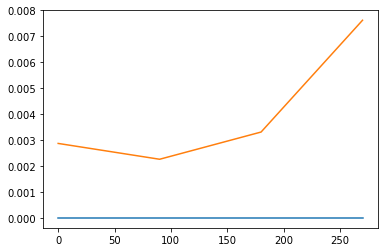

In [5]:
model = Model().to(device)
check_equivariance(model, dataset)

In [6]:
snn.set_backend('Pytorch')

Already at Backend Pytorch
